## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

In [2]:
# specify if you want to add high-resolution P1D (only working for Pedersen23 emulator)
add_hires=False
if add_hires:
    kmax_Mpc=8
else:
    kmax_Mpc=4

### Setup emulator

The emulator will be used both to make a mock, and in the likelihood 

In [3]:
#emulator=nn_emulator.NNEmulator(training_set='Nyx23',emulator_label='Cabayol23_Nyx')
emulator=nn_emulator.NNEmulator(training_set='Cabayol23',emulator_label='Cabayol23')
#emulator=gp_emulator.GPEmulator(training_set='Pedersen21',kmax_Mpc=kmax_Mpc)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


### Create mock P1D data

Use Lya theory to mimic mock data

In [4]:
data=mock_data.Mock_P1D(emulator=emulator,data_label="QMLE_Ohio")
#data=mock_data.Mock_P1D(emulator=emulator,data_label="Chabanier2019")

will read P1D file /Users/font/Projects/DESI/p1d_forecast//private_data/p1d_measurements//QMLE_Ohio//desi-y5fp-1.5-4-o3-deconv-power-qmle_kmax0.04.txt
2 low-k bins not included


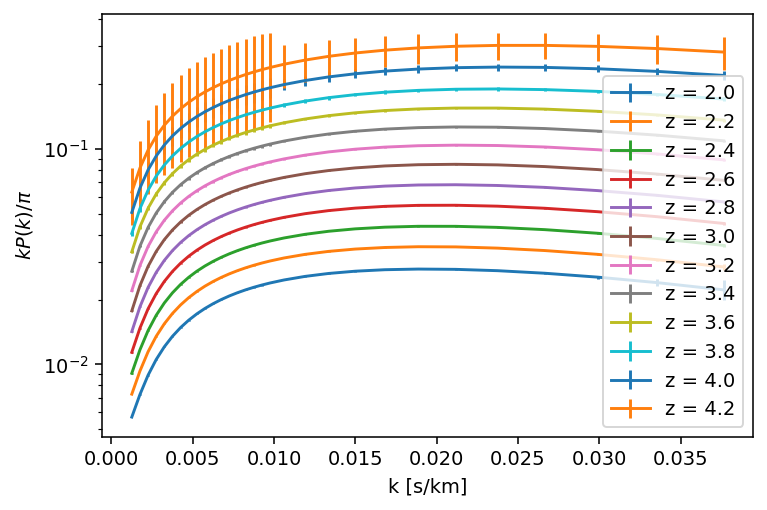

In [5]:
data.plot_p1d()

In [6]:
# check if we also need mock extra_p1d
if add_hires:
    extra_data=mock_data.Mock_P1D(emulator=emulator,data_label="Karacayli2022")
else:
    extra_data=None

### Set free parameters and theory

In [7]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [8]:
theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)

In [9]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_kF_1 = 0.0 , -0.4 , 0.4


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [10]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
chi2 = -0.0


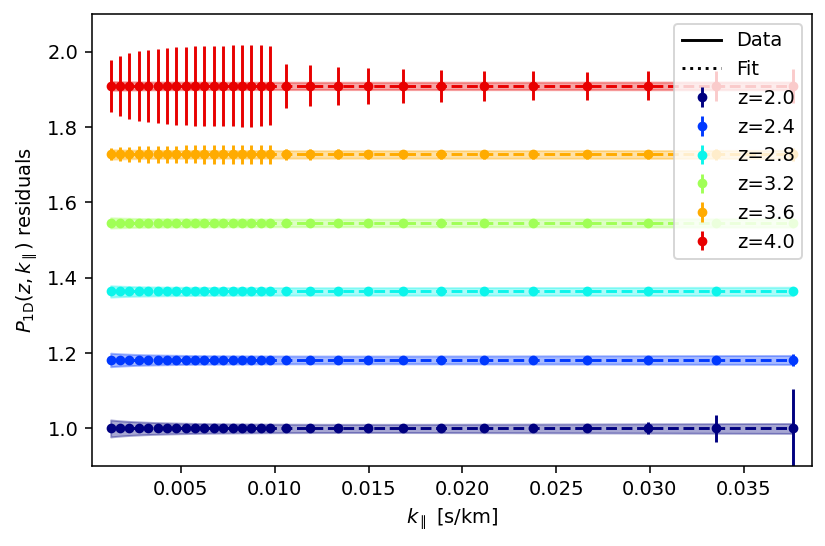

In [11]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print('chi2 =',like.get_chi2(values=test_values))
like.plot_p1d(values=test_values,residuals=True,plot_every_iz=2)

In [12]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=2)

### Run iminuit minimizer

In [13]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.00002
ini_values=2*ini_sigma*np.random.random(len(like.free_params))+0.5-ini_sigma
print('ini values',ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

ini values [0.49999704 0.50000297 0.49998921 0.49998801 0.5000046  0.49998015
 0.50001549 0.49998539 0.5000009  0.50001474]
As = 2.0999934957447862e-09 , 1e-09 , 3.2e-09
ns = 0.9650005054180388 , 0.88 , 1.05
ln_tau_0 = -2.1585302356630365e-06 , -0.1 , 0.1
ln_sigT_kms_0 = -9.589843742385806e-06 , -0.4 , 0.4
ln_gamma_0 = 1.8400993181677539e-06 , -0.2 , 0.2
ln_kF_0 = -7.941761619945087e-06 , -0.2 , 0.2
ln_tau_1 = 6.195587194779417e-06 , -0.2 , 0.2
ln_sigT_kms_1 = -1.1689038364792737e-05 , -0.4 , 0.4
ln_gamma_1 = 7.196573331702538e-07 , -0.4 , 0.4
ln_kF_1 = 1.1792091295870222e-05 , -0.4 , 0.4


In [14]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,ini_values=ini_values)

In [15]:
minimizer.minimize(compute_hesse=True)

In [16]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values=np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

1.2291072056851159e-05

In [17]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

0.00035918211338905204

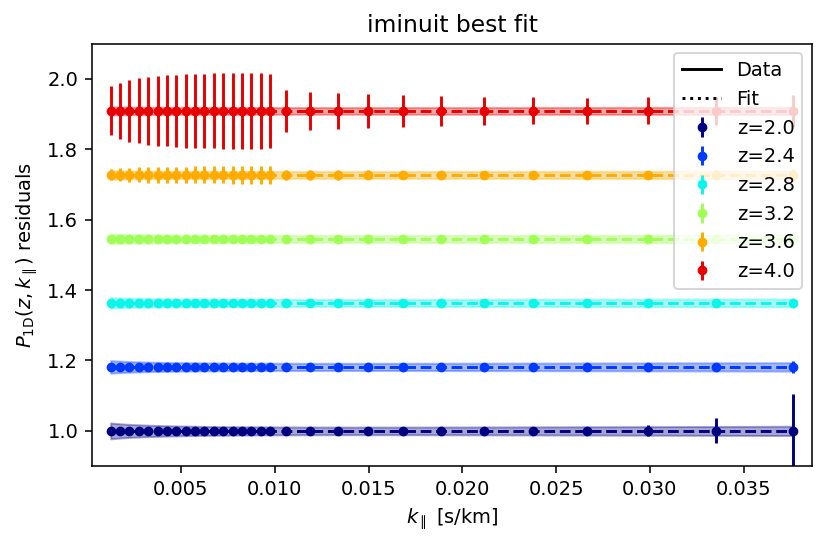

In [18]:
minimizer.plot_best_fit(plot_every_iz=2)

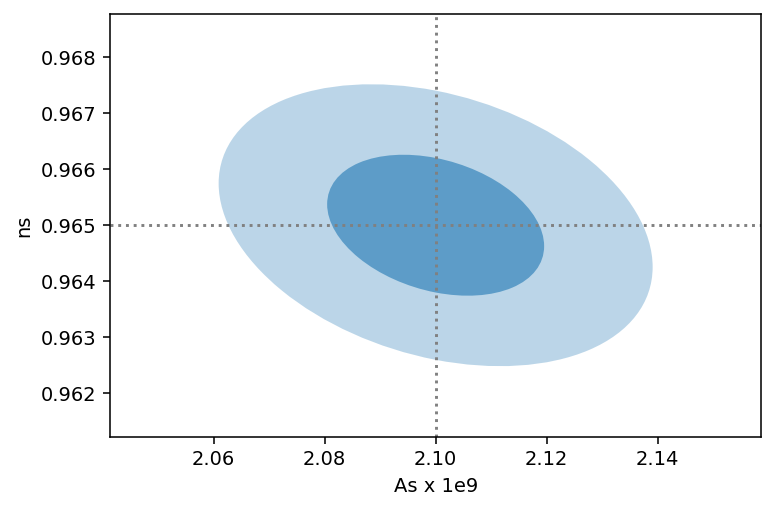

In [19]:
minimizer.plot_ellipses('As','ns')

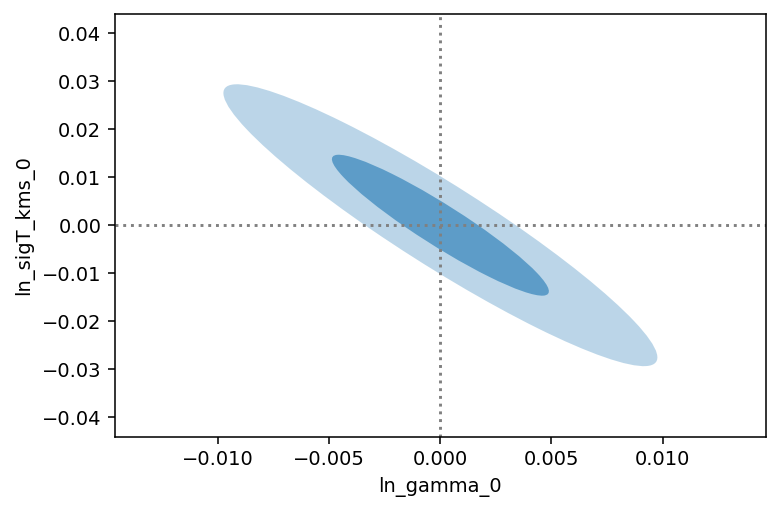

In [20]:
minimizer.plot_ellipses('ln_gamma_0','ln_sigT_kms_0')

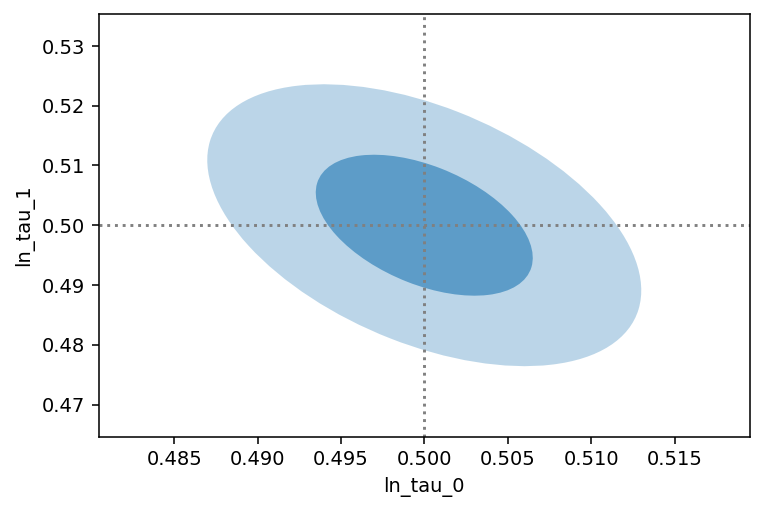

In [21]:
minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [22]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -450.9                     │              Nfcn = 446              │
│ EDM = 3.69e-06 (Goal: 0.0001)    │           time = 11.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.500   │   0.008   │            │            │         │         │       │
│ 1 │ x1   │   0.500   │   0.012   │            │            │         │         │       │
│ 2 │ x2   │   0.500   │   0.013   │            │            │         │         │       │
│ 3 │ x3   │   0.500   │   0.007   │            │            │         │         │       │
│ 4 │ x4   │   0.500   │   0.009   │            │            │         │         │       │
│ 5 │ x5   │   0.500   │   0.025   │            │            │         │         │       │
│ 6 │ x6   │   0.500   │   0.015   │            │            │         │         │       │
│ 7 │ x7   │   0.500   │   0.031   │            │            │         │         │       │
│ 8 │ x8   │   0.500   │   0.018   │            │            │         │         │       │
│ 9 │ x9   │   0.50    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │  7.22e-05  4.78e-05  -9.1e-05 -4.12e-05 -3.28e-05 -8.83e-05 -5.96e-05  0.000124 -7.43e-05  0.000117 │
│ x1 │  4.78e-05  0.000141 -8.72e-05 -3.92e-05 -3.29e-05  -0.00025 -5.56e-05  6.07e-05 -6.97e-05  0.000149 │
│ x2 │  -9.1e-05 -8.72e-05   0.00016  3.68e-05  8.18e-05  0.000117  0.000121 -0.000145  0.000125  -0.00019 │
│ x3 │ -4.12e-05 -3.92e-05  3.68e-05  4.63e-05  -3.5e-07  7.74e-05  1.83e-05 -2.89e-05  3.03e-05  -0.00011 │
│ x4 │ -3.28e-05 -3.29e-05  8.18e-05  -3.5e-07  7.42e-05  6.31e-05  5.88e-05 -6.28e-05  9.63e-05 -8.39e-05 │
│ x5 │ -8.83e-05  -0.00025  0.000117  7.74e-05  6.31e-05  0.000639  3.71e-05  -0.00021  0.000172 -0.000141 │
│ x6 │ -5.96e-05 -5.56e-05  0.000121  1.83e-05  5.88e-05  3.71e-05  0.000214 -0.000207  0.000203 -0.000118 │
│ x7 │  0.000124  6.07e-05 -0.000145 -2.89e-05 -6.28e-05  -0.00021 -0.000207  0.000948 -0.000308  4.38e-05 │
│ x8 │ -7.43e-05 -6.97e-05  0.000125  3.03e-05  9.63e-05  0.000172  0.000203 -0.000308  0.000315 -0.000137 │
│ x9 │  0.000117  0.000149  -0.00019  -0.00011 -8.39e-05 -0.000141 -0.000118  4.38e-05 -0.000137   0.00162 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [23]:
minimizer.minimizer.errors

<ErrorView x0=0.008498712283920965 x1=0.011876474434266565 x2=0.012649673376307916 x3=0.006803137527962396 x4=0.008611603685335336 x5=0.025278982063082853 x6=0.014644470102515376 x7=0.030794504703896372 x8=0.017749366315459984 x9=0.040204578368746455>

In [24]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(-1.9504238699952214e-06, 0.0025299346752615834)

In [25]:
minimizer.best_fit_value('ns',return_hesse=True)

(0.9650020433983989, 0.0020190006538253163)